# **SolvingMazes: Dyna-Q+ Agent**
[Achi's Projects](https://github.com/QuantumNano-AI/PROJECTS)

**The DynaQ+ algorithm is more robust than DynaQ. It provides a solution to environment dynamics changing and thus making its model inaccurate**

**For the DynaQ+ Agent we will be adding two new parameters `state visitation count` $\tau$ and `scaling parameter` $\kappa$.**

**Where $r$ is the modeled reward for a transition which hasn't been visited in $\tau(s,a)$ time steps, the planning updates are done using $r + \kappa \sqrt{\tau(s,a)}$ as the reward instead**



In [1]:
import numpy as np
import sklearn.preprocessing as sc
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import operator
        
class Maze:
    def __init__(self, maze, rewards = {'goal':1000000,'wall':-15, 'other':-1}):
                
        """# Read file and set height and width of maze
        with open(filename) as f:
            maze = f.read()"""
        self.rewards=rewards
        # Validate start and goal
        if maze.count("A") != 1:
            raise Exception("maze must have exactly one start point")
        if maze.count("B") != 1:
            raise Exception("maze must have exactly one goal")
        
        self.actions =  ["up", "down", "left", "right"]
        
        # Determine height and width of maze
        maze = maze.splitlines()
        self.height = len(maze)
        self.width = max(len(line) for line in maze)
        self.states = []
        
                
        # Keep track of walls
        self.walls = []
        self.wall_cords = []
        for i in range(self.height):
            row = []
            for j in range(self.width):
                try:
                    if maze[i][j] == "A":
                        self.start = (i, j)
                        row.append(False)
                        self.states.append((i,j))
                    elif maze[i][j] == "B":
                        self.goal = (i, j)
                        row.append(False)
                        self.states.append((i,j))
                    elif maze[i][j] == " ":
                        row.append(False)
                        self.states.append((i,j))
                    else:
                        row.append(True)
                        self.wall_cords.append((i,j))
                except IndexError:
                    row.append(False)
                    self.states.append((i,j))
            self.walls.append(row)
            

        self.state_count = len(self.states)
        self.solution = None
        self.V = dict(zip(self.states, self.state_count*[0]))
        self.pi = dict(zip(self.states, self.state_count*[0]))
        for s in self.states:
            avail_actions = self.actions
            self.pi[s] = avail_actions[0]
        self.pi1 = dict(zip(self.states, self.state_count*[0]))
        
    def print(self):
        solution = self.solution[1] if self.solution is not None else None
        print()
        for i, row in enumerate(self.walls):
            for j, col in enumerate(row):
                if col:
                    print("#", end="")
                elif (i, j) == self.start:
                    print("A", end="")
                elif (i, j) == self.goal:
                    print("B", end="")
                elif solution is not None and (i, j) in solution:
                    print("*", end="")
                else:
                    print(" ", end="")
            print()
        print()

    def neighbors(self, state, a = None):
        """This function takes in a state and returns all available actions for that state the next state 
            and reward if each action is take, with a specific transition probability"""
        row, col = state
        candidates = [
            ("up", (row - 1, col)),
            ("down", (row + 1, col)),
            ("left", (row, col - 1)),
            ("right", (row, col + 1))
        ]
        terminal = False
        result = []
        for action, (r, c) in candidates:
            if (r,c) == self.goal: terminal = True
            if 0 <= r < self.height and 0 <= c < self.width and not self.walls[r][c]:
                if (row, col) == self.goal: 
                    (r, c) = self.goal; terminal = True
                reward = self.rewards['goal'] if ((r,c) == self.goal) or (state == self.goal) else self.rewards['other']
                trans_prob = 1
                result.append((action, (r, c), reward, trans_prob, terminal))
                
        actions = [tup[0] for tup in result]

        if a:
            R = []
            if a in actions:
                inx = actions.index(a)
                R.append((result[inx]))
                return R
            else: 
                R.append((a, (row,col), self.rewards['wall'], 1, terminal))
                return R
        return result
    
    def plot_state_values(self):
        val = np.array(list(self.V.values())).reshape(-1,1)
        va = sc.MinMaxScaler(feature_range=(0, 255)).fit_transform(val).flatten()
        V = {}
        for i in range(len(va)):
            V[list(self.V.keys())[i]] = va[i]

        # create a black image
        img  = np.ones((self.height,self.width,3), np.uint8)

        for item in V.items():
            (r,c),vx = item
            img[r,c] = [0,vx,0]

        for r,c in self.wall_cords:
            img[r,c] = [150,5,150]

        img[self.start[0],self.start[1]] = [255,0,0]
        img[self.goal[0],self.goal[1]] = [100,100,255]
        def showimg(img):
            plt.figure(figsize = (15,15))
            plt.imshow(img, cmap='viridis')
            plt.xticks([])
            plt.yticks([])
            #plt.colorbar()
            plt.show()
        showimg(img)
        
        def policy_(s):
            row, col = s
            candidates = [
                ("up", (row - 1, col)),
                ("down", (row + 1, col)),
                ("left", (row, col - 1)),
                ("right", (row, col + 1))
            ]


            if s in self.wall_cords:
                return ('WALL!!!')
            else:
                values = {a:self.V[r,c] for a,(r,c) in candidates if 0 <= r < self.height and 0 <= c < self.width and not self.walls[r][c]}
                values = {v:k for k,v in values.items()}
                best = values[max(values)]
            return best
        
        pi = np.zeros((self.height, self.width)).astype('str')
        pi = np.where(pi=='0.0', 'wall', pi)
        candidates = {
                    "up": [255,0,0],
                    "down": [0,0,255],
                    "left": [0,255,0],
                    "right": [255,255,0]
        }
        for item in self.pi.keys():
            action = policy_(item)
            
            r,c = item
            pi[r,c] = action
            img[r,c] = candidates[action]
            
        img[self.start[0],self.start[1]] = [255,0,0]
        img[self.goal[0],self.goal[1]] = [100,100,255]
        def showimg(img):
            plt.figure(figsize = (15,15))
            plt.imshow(img, cmap='viridis', )
            plt.yticks(list(range(self.height)))
            plt.xticks(list(range(self.width)))
            plt.title("POLICY\n\nRED  =>  up\nBLUE  =>  down\nGREEN  =>  left\nYELLOW  =>  right")
            #plt.colorbar()
            plt.show()
        showimg(img)
        return img

In [2]:
class DynaQ(Maze):
    def __init__(self, maze, rewards = {'goal':1000000,
                                            'wall':-15, 
                                            'other':-1}, 
                             info = {} ):
        
        Maze.__init__(self, maze, rewards)
        self.epsilon = info.get('epsilon', 0.9) # Exporation parameter
        self.r = np.random.RandomState(seed=12345)
        self.episodes =info.get('episodes', 200)
        self.max_steps =info.get('max_steps', 1500)
        self.alpha = info.get('alpha',0.1) # step size
        self.gamma = info.get('gamma',.99) # discount factor
        self.kappa = info.get('kappa',.001) # Scalling parameter
        self.planning_steps = info.get('planning_steps',50)
        self.tau = pd.DataFrame(np.zeros((self.state_count, len(self.actions))),columns=self.actions, index=self.states).to_dict(orient='index')
        
    def func_q(self, states,n_states,n_actions,kind = 'random'):
        if kind=='ones':
            return dict(zip(states,np.ones((n_states,n_actions)).tolist()))
        elif kind == 'zeros':
            return dict(zip(states,np.zeros((n_states,n_actions)).tolist()))
        elif kind =='random':
            return dict(zip(states,np.round(self.r.randn(n_states,n_actions),2).tolist()))
        else :  raise NameError("Wrong input: please use ['ones', 'zeros', 'random']")  
    
    def argmax(self, test_array):
        return self.r.choice(np.flatnonzero(np.array(test_array)==np.array(test_array).max()))
    
    def epsilon_greedy(self, Q, epsilon, actions, state, train=False):
        current_q = Q[state]
        if self.r.rand() < epsilon:
            action = self.r.choice(actions)
            return action
        else:
            action = self.argmax(current_q)
        return actions[action]
    
    def sigmoid(self,a):
        import numpy as np
        s = np.divide(1,1+np.exp(-a))
        return s
    
    def run(self):
        self.Q = self.func_q(self.states,self.state_count,len(self.actions),kind = 'zeros')
        self.model = {} # model is a dictionary of dictionaries, which maps states to actions to (reward, next_state) tuples
        def update_model(s,a,s_,reward):
            if s in self.model: self.model[s][a] = (s_,reward) # If the agent has been in this state before, update the action/reward
            else: 
                self.model[s] = {a:(s_,reward)} # else add new state and action to model
                # actions that had never been tried are now going to be considered. The initial model for such actions would be
                # to lead back to the previous state and have a reward of zero
                for action in self.actions:
                    if action != a:
                        self.model[s][a] = (s, 0)
                
        def planning():
            for i in range(self.planning_steps):
                s = list(self.model.keys())[self.r.randint(len(self.model.keys()))]
                a = self.r.choice(list(self.model[s].keys()))
                (s_,reward) = self.model[s][a]
                reward += self.kappa*np.sqrt(self.tau[s][a])
                q_ = self.Q[s_]
                a_ = self.actions[self.argmax(q_)] # Action in the next state does not follow policy. It is rather selected to maximise utility.
                if terminal:
                    self.Q[s][self.actions.index(a)] += self.alpha * (reward - self.Q[s][self.actions.index(a)])
                else:
                    self.Q[s][self.actions.index(a)] += self.alpha * (reward + self.gamma*max(q_) \
                                                                      - self.Q[s][self.actions.index(a)])  
                
        self.time_steps = pd.DataFrame()

        for episode in range(self.episodes):

            total_reward = 0 # This sets the total reward obtained during this episode
            s = self.states[self.r.randint(len(self.states))]
            a = self.epsilon_greedy(Q=self.Q, epsilon=self.epsilon, actions=self.actions, state=s)
            t = 0 
            terminal = False
            while t < self.max_steps:
                t+=1
                self.tau = {k:{kk:vv+1 for kk,vv in v.items()} for k,v in self.tau.items()}
                self.tau[s][a] = 0
                
                _,s_, reward, p,terminal = self.neighbors(s,a)[0]
                total_reward += reward
                q_ = self.Q[s_] # Action values in the next state
                a_ = self.epsilon_greedy(Q=self.Q, epsilon=self.epsilon, actions=self.actions, state=s)
                reward += self.kappa*np.sqrt(self.tau[s][a])
                if terminal:
                    self.Q[s][self.actions.index(a)] += self.alpha * (reward - self.Q[s][self.actions.index(a)])
                else:
                    self.Q[s][self.actions.index(a)] += self.alpha * (reward + self.gamma*self.Q[s_][self.actions.index(a_)] \
                                                                      - self.Q[s][self.actions.index(a)])  
                update_model(s,a,s_,reward)
                
                # Carry out planning only when there is a complete episode with rewards returned
                if len(self.time_steps)>0: 
                    ts = self.time_steps[self.time_steps.rewards!=0]
                    if len(ts)>0:planning()
                    
                s, a = s_, a_
                if terminal:
                    self.time_steps = self.time_steps.append(
                        pd.Series({'episode':int(episode), 'steps':t, 'rewards':total_reward}), ignore_index=True)
                    break
            if t%10==0:
                print(f'.',end='')
        self.pi = {}
        self.V = {}
        for k,v in self.Q.items():
            self.pi[(k)] = self.actions[self.argmax(v)]
            self.V[(k)] = max(v)
        max_r = max([v for k,v in self.V.items()])
        self.V[self.goal] = max_r
        img = self.plot_state_values()  
        #return V,pi

In [3]:
maze0 = """#####################
A                  ##
## ############## # #
## ####### ###### # #
##                # #
## ####### ######   #
##         ###### # #
###################B#"""

In [4]:
print(maze0)

#####################
A                  ##
## ############## # #
## ####### ###### # #
##                # #
## ####### ######   #
##         ###### # #
###################B#


.....

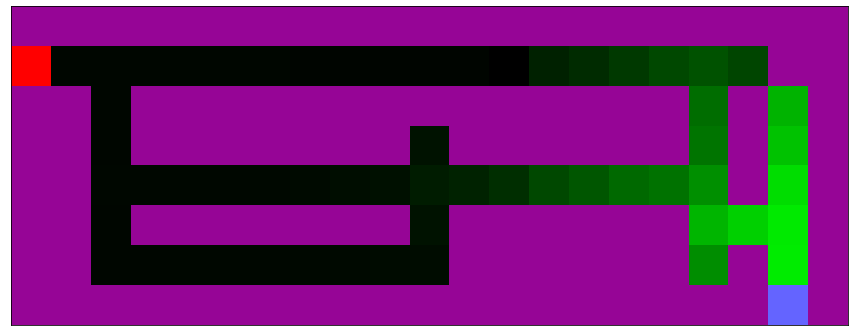

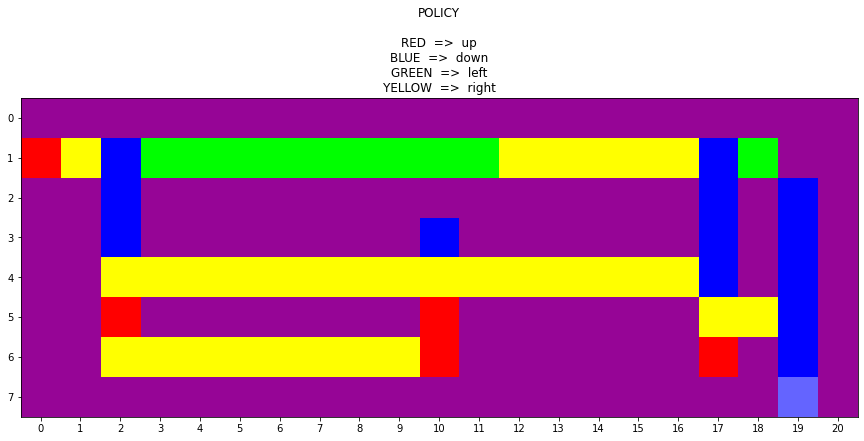

In [5]:
info = {'episodes': 50,'max_steps': 5000,'alpha': 0.1,'epsilon':.1, 'planning_steps':20, 'kappa':.5}
rewards = {'goal':10000,'wall':-1, 'other':0}
m = DynaQ(maze = maze0, rewards = rewards, info = info)
m.run()
#t = m.time_steps; t[t.rewards!=0][['episode','steps']]

In [6]:
maze = """############################
##     #####              ##
##B### ##### ##### ### ##  #
###                ### ### #
# ### ##### ########## ### #
# ### #####            ### #
#           # ####### #### #
# #### #### # ####### #### #
# ##    ### #              #
#  ### #### # ######## ### #
## ##   ###       #### ### #
## #### #### #### #### ### #
## #### #### #### #### ### #
##                         #
###A########################"""

In [7]:
print(maze)

############################
##     #####              ##
##B### ##### ##### ### ##  #
###                ### ### #
# ### ##### ########## ### #
# ### #####            ### #
#           # ####### #### #
# #### #### # ####### #### #
# ##    ### #              #
#  ### #### # ######## ### #
## ##   ###       #### ### #
## #### #### #### #### ### #
## #### #### #### #### ### #
##                         #
###A########################


..............................

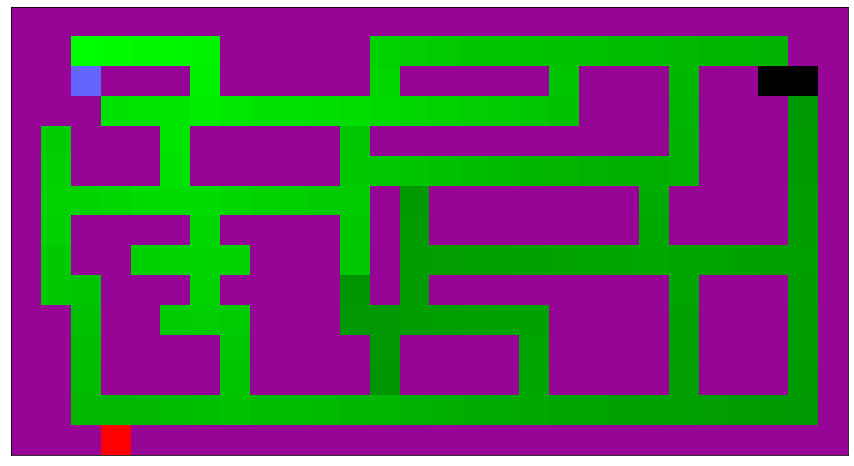

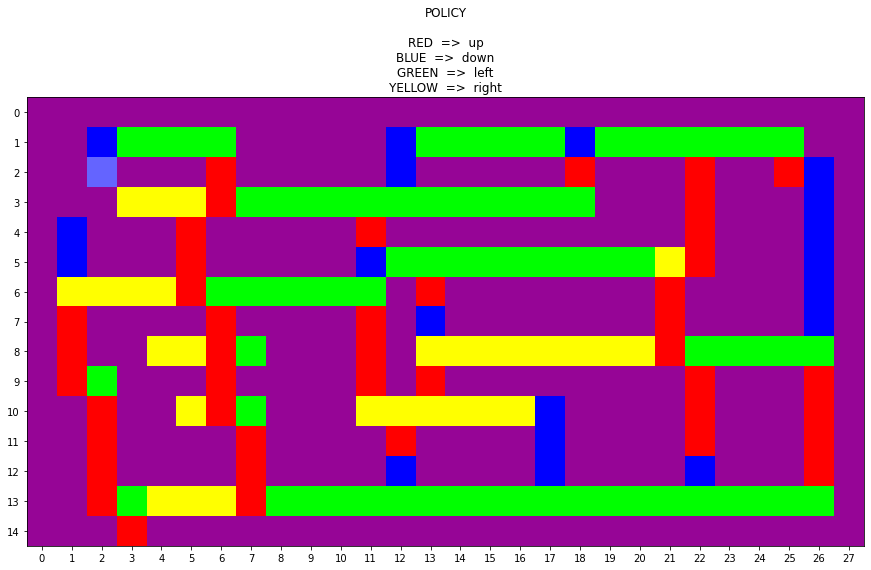

In [12]:
info = {'episodes': 100,'max_steps': 500,'alpha': 0.1,'epsilon':.1, 'planning_steps':50, 'kappa':.5}
rewards = {'goal':10000000,'wall':-500, 'other':0}
m = DynaQ(maze = maze, rewards = rewards, info = info)
m.run()
#t = m.time_steps; t[t.rewards!=0][['episode','steps']]

In [9]:
maze1 = """#####################
##                  #
## ### ############ #
##              ### #
## ### ############B#
###### ##############
##         ######## #
## #### ## ######## #
## ####             #
## ############ ### #
## #      ##### ### #
## # ####       ### #
## # ############## #
##                  #
## ################ #
##A##################"""

In [10]:
print(maze1)

#####################
##                  #
## ### ############ #
##              ### #
## ### ############B#
###### ##############
##         ######## #
## #### ## ######## #
## ####             #
## ############ ### #
## #      ##### ### #
## # ####       ### #
## # ############## #
##                  #
## ################ #
##A##################


....

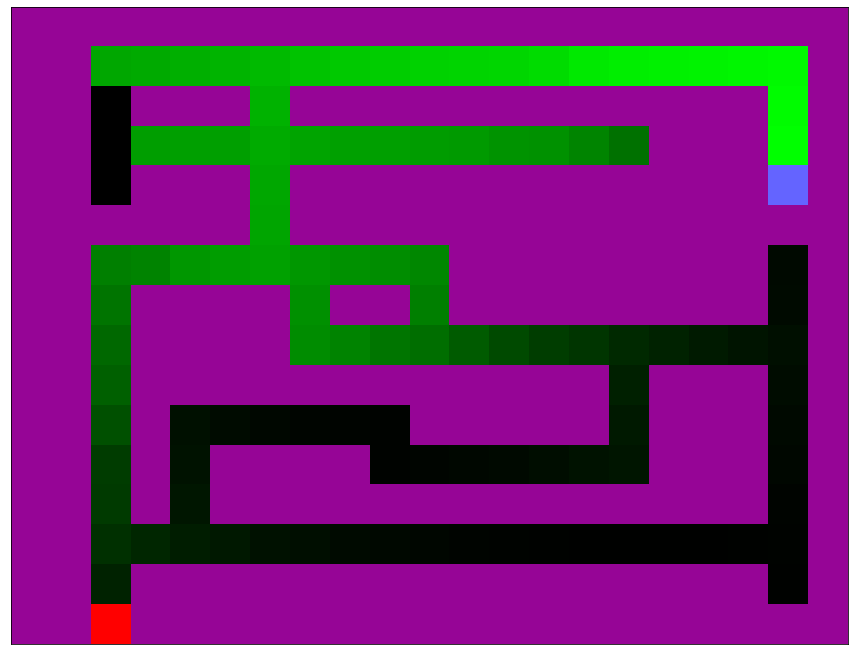

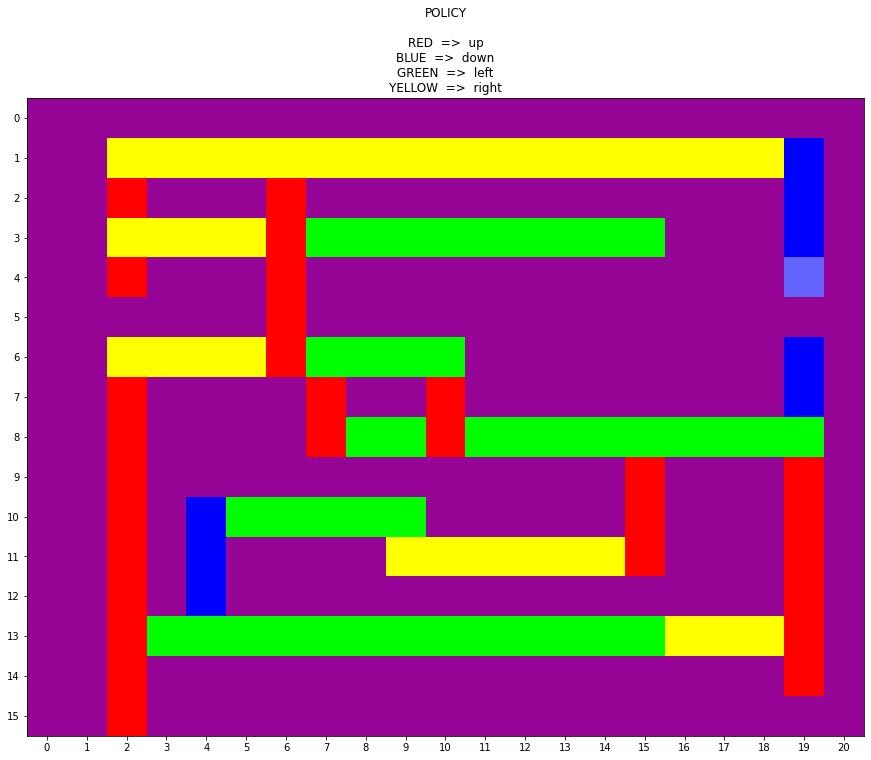

In [11]:
info = {'episodes': 50,'max_steps': 5000,'alpha': 0.1,'epsilon':.1, 'planning_steps':20}
rewards = {'goal':100000000,'wall':-100, 'other':0}
m = DynaQ(maze = maze1, rewards = rewards, info = info)
m.run()
#t = m.time_steps; t[t.rewards!=0][['episode','steps']]